In [12]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [13]:

# EDA from week2 Mod B
df_diabetes = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")
df_ckd = pd.read_csv("Chronic_Kidney_Dsease_data.csv")
df_hypertension = pd.read_csv("hypertension_dataset.csv")
df_alzheimers = pd.read_csv("alzheimers_disease_data.csv")

# Generate basic summaries
diabetes_desc = df_diabetes.describe(include='all')
ckd_desc = df_ckd.describe(include='all')
hypertension_desc = df_hypertension.describe(include='all')
alzheimers_desc = df_alzheimers.describe(include='all')

# Check for duplicates
diabetes_duplicates = df_diabetes.duplicated().sum()
ckd_duplicates = df_ckd.duplicated().sum()
alzheimers_duplicates = df_alzheimers.duplicated().sum()
_duplicates = df_hypertension.duplicated().sum()
# Check for nulls
diabetes_nulls = df_diabetes.isnull().sum()
ckd_nulls = df_ckd.isnull().sum()
hypertension_nulls = df_hypertension.isnull().sum()
alzheimers__nulls = df_alzheimers.isnull().sum()

# Display descriptive summaries

print("\n===alzheimers-Summary ===")
print(ckd_desc)
# Return duplicates and total null values per dataset
print("\n=== Duplicates in alzheimers_duplicates Dataset ===")
print(f"alzheimers: {alzheimers_duplicates}")

# Return nulls
print("\n=== Total Null Values in alzheimers Dataset ===")
print(f"Diabealzheimerstes: {alzheimers__nulls.sum()}")


#Diabetes Dataset
#Duplicates: 24,206 rows — significant duplication, should be reviewed or removed
#Missing values: None
#Usability: Usable after deduplication

#Chronic Kidney Disease (CKD) Dataset
#Duplicates: None
#Missing values: None\
#Usability: Clean and ready for analysis

#Hypertension Dataset
#Duplicates: None
#Missing values: None
#Usability: Ready to use

# Steps to clean up Diabetes Dataset 
#Remove duplicates from the diabetes dataset: df_diabetes.drop_duplicates(inplace=True)
#Consider class balance checks (e.g., ratio of positive to negative labels)
#Identify categorical features and apply encoding (pd.get_dummies or OrdinalEncoder)
#Explore mode, median, and outliers for inconsistent data (e.g., age = 0)

#1 Remove Duplicates
df_diabetes.drop_duplicates(inplace=True)
#2 Handling any missing values
df_diabetes.fillna(df_diabetes.median(), inplace=True)  # For numeric columns
df_diabetes.fillna("Unknown", inplace=True)    # For categorical columns
#3Check for Inconsistencies
  #Negative ages or values outside expected range
  #Incorrect data types (e.g., numeric coded as string)
#4 Check for Class Imbalance

print(df_diabetes['Diabetes_binary'].value_counts(normalize=True))
print(df_hypertension['Hypertension'].value_counts(normalize=True))
#print(df_ckd['classification'].value_counts(normalize=True)) 

# Encode Categorical Variables
# One-hot encoding (for logistic regression, tree-based models)
df = pd.get_dummies(df_diabetes, drop_first=True)

# Or ordinal encoding if there is a natural order
#print("Arun")
#print(df_ckd.columns)
categorical_cols = df_ckd.select_dtypes(include=['object', 'category']).columns.tolist()
#print("Categorical columns:", categorical_cols)

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df_ckd[['DoctorInCharge']] = encoder.fit_transform(df_ckd[['DoctorInCharge']])




===alzheimers-Summary ===
          PatientID          Age       Gender   Ethnicity  \
count   1659.000000  1659.000000  1659.000000  1659.00000   
unique          NaN          NaN          NaN         NaN   
top             NaN          NaN          NaN         NaN   
freq            NaN          NaN          NaN         NaN   
mean     830.000000    54.441230     0.515371     0.71308   
std      479.056364    20.549757     0.499914     1.00043   
min        1.000000    20.000000     0.000000     0.00000   
25%      415.500000    36.000000     0.000000     0.00000   
50%      830.000000    54.000000     1.000000     0.00000   
75%     1244.500000    72.000000     1.000000     1.00000   
max     1659.000000    90.000000     1.000000     3.00000   

        SocioeconomicStatus  EducationLevel          BMI      Smoking  \
count           1659.000000     1659.000000  1659.000000  1659.000000   
unique                  NaN             NaN          NaN          NaN   
top                  

In [14]:
TARGET_COLUMN = "MMSE"  

In [15]:
df=df_alzheimers
# Drop obvious ID columns if present (prevents leakage / meaningless signal)
for col in ["PatientID", "patient_id", "ID", "Id"]:
    if col in df.columns:
        df = df.drop(columns=[col])

# Treat codes that are actually categories as categorical
# (Diagnosis is int-coded in your file but conceptually categorical)
if "Diagnosis" in df.columns:
    df["Diagnosis"] = df["Diagnosis"].astype("category").astype(str)

# Separate X, y
y = df[TARGET_COLUMN]
X = df.drop(columns=[TARGET_COLUMN])

# Identify categorical vs numeric
categorical_cols = [c for c in X.columns if X[c].dtype == "object"]
numeric_cols     = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]

print("Categorical cols:", categorical_cols)
print("Numeric cols:", numeric_cols, "\n")



Categorical cols: ['Diagnosis', 'DoctorInCharge']
Numeric cols: ['Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'FunctionalAssessment', 'MemoryComplaints', 'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 'DifficultyCompletingTasks', 'Forgetfulness'] 



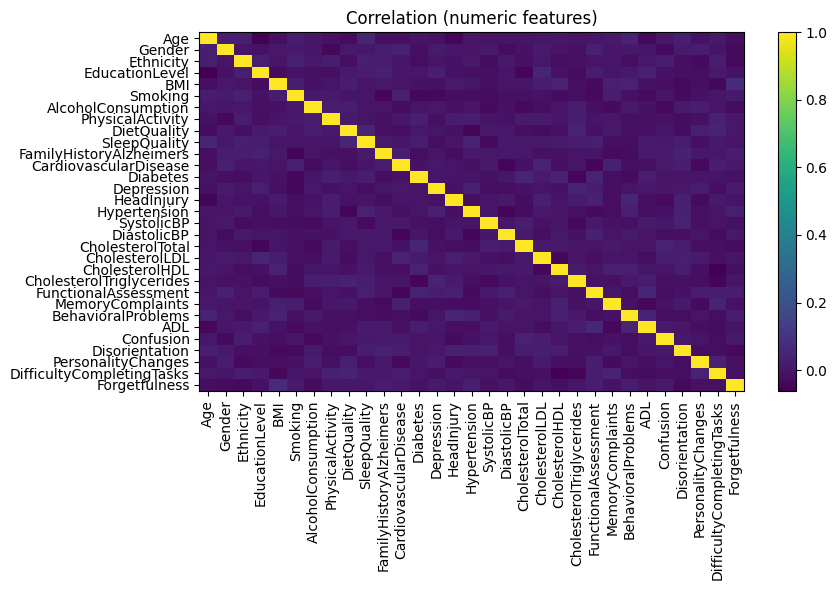

In [16]:
# ---------- 2) Correlation (numeric only, matplotlib) ----------
if len(numeric_cols) > 1:
    corr = df[numeric_cols].corr()
    plt.figure(figsize=(9,6))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation (numeric features)")
    plt.colorbar()
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for correlation matrix.\n")



In [17]:
# ---------- 3) VIF (multicollinearity) without statsmodels ----------
from sklearn.linear_model import LinearRegression

def compute_vif_sklearn(df_num: pd.DataFrame) -> pd.DataFrame:
    """
    VIF_i = 1 / (1 - R2_i), where R2_i is from regressing Xi on all other X's.
    Works on numeric features only. Drops rows with NA.
    """
    Xn = df_num.copy().dropna()
    cols = Xn.columns.tolist()
    rows = []
    if len(cols) < 2:
        return pd.DataFrame({"feature": cols, "VIF": [np.nan]*len(cols)})
    # Standardize for numerical stability
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(Xn.values)
    for i, col in enumerate(cols):
        y_i = X_scaled[:, i]
        X_others = np.delete(X_scaled, i, axis=1)
        lr = LinearRegression().fit(X_others, y_i)
        r2_i = lr.score(X_others, y_i)
        vif = np.inf if (1 - r2_i) == 0 else 1.0 / (1.0 - r2_i)
        rows.append((col, float(vif)))
    return pd.DataFrame(rows, columns=["feature", "VIF"]).sort_values("VIF", ascending=False)

if len(numeric_cols) >= 2:
    vif_df = compute_vif_sklearn(df[numeric_cols])
    print("Top VIFs:\n", vif_df.head(15), "\n")
else:
    print("Not enough numeric columns to compute VIF.\n")



Top VIFs:
                       feature       VIF
29  DifficultyCompletingTasks  1.018527
22       FunctionalAssessment  1.017793
3              EducationLevel  1.017091
0                         Age  1.016964
4                         BMI  1.016440
27             Disorientation  1.015731
24         BehavioralProblems  1.015725
15               Hypertension  1.014843
21   CholesterolTriglycerides  1.014649
9                SleepQuality  1.014584
12                   Diabetes  1.014341
30              Forgetfulness  1.014258
8                 DietQuality  1.014217
25                        ADL  1.014142
5                     Smoking  1.013992 



In [18]:
# ---------- 4) Preprocessing pipelines ----------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess_baseline = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)



In [20]:
# ---------- 5) Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train/Test shapes:", X_train.shape, X_test.shape, "\n")

# ---------- 6) Baseline Linear Regression ----------
baseline = Pipeline(steps=[
    ("prep", preprocess_baseline),
    ("lin", LinearRegression())
])

baseline.fit(X_train, y_train)
pred_tr = baseline.predict(X_train)
pred_te = baseline.predict(X_test)

print("Baseline R2 (train):", round(r2_score(y_train, pred_tr), 3))
print("Baseline R2 (test) :", round(r2_score(y_test, pred_te), 3))
# ----- Baseline RMSE -----
mse_te = mean_squared_error(y_test, pred_te)
rmse_te = np.sqrt(mse_te)
print("Baseline RMSE (test):", round(rmse_te, 3))




Train/Test shapes: (1719, 33) (430, 33) 

Baseline R2 (train): 0.09
Baseline R2 (test) : 0.107
Baseline RMSE (test): 8.039


In [22]:
# ---------- 7) Polynomial + Interaction Terms (degree=2) ----------
# Apply degree=2 polynomial expansion to *numeric* features only (categoricals stay one-hot).
poly_num = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=False))
])

preprocess_poly = ColumnTransformer(
    transformers=[
        ("num_poly", poly_num, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ],
    remainder="drop"
)

poly_model = Pipeline(steps=[
    ("prep", preprocess_poly),
    ("lin", LinearRegression())
])

poly_model.fit(X_train, y_train)
pred_poly = poly_model.predict(X_test)

print("Poly+Interactions R2 (test):", round(r2_score(y_test, pred_poly), 3))

mse_poly = mean_squared_error(y_test, pred_poly)
rmse_poly = np.sqrt(mse_poly)
print("Poly+Interactions RMSE (test):", round(rmse_poly, 3))




Poly+Interactions R2 (test): -0.305
Poly+Interactions RMSE (test): 9.719


In [23]:
# ---------- 8) Cross-Validation (3-fold to keep it quick) ----------
kf3 = KFold(n_splits=3, shuffle=True, random_state=42)

cv_r2_base = cross_val_score(baseline, X, y, cv=kf3, scoring="r2")
cv_r2_poly = cross_val_score(poly_model, X, y, cv=kf3, scoring="r2")

cv_rmse_base = np.sqrt(-cross_val_score(baseline, X, y, cv=kf3, scoring="neg_mean_squared_error"))
cv_rmse_poly = np.sqrt(-cross_val_score(poly_model, X, y, cv=kf3, scoring="neg_mean_squared_error"))

print("3-fold CV R2  (baseline): mean=%.4f, std=%.4f" % (cv_r2_base.mean(), cv_r2_base.std()))
print("3-fold CV R2  (poly)    : mean=%.4f, std=%.4f" % (cv_r2_poly.mean(), cv_r2_poly.std()))
print("3-fold CV RMSE(baseline): mean=%.4f, std=%.4f" % (cv_rmse_base.mean(), cv_rmse_base.std()))
print("3-fold CV RMSE(poly)    : mean=%.4f, std=%.4f" % (cv_rmse_poly.mean(), cv_rmse_poly.std()), "\n")



3-fold CV R2  (baseline): mean=0.0671, std=0.0192
3-fold CV R2  (poly)    : mean=-0.4439, std=0.0147
3-fold CV RMSE(baseline): mean=8.3137, std=0.0988
3-fold CV RMSE(poly)    : mean=10.3431, std=0.0950 



In [24]:
# ---------- 9) Feature names + coefficients (baseline) ----------
def feature_names_after_preprocess(preprocessor: ColumnTransformer, X_frame: pd.DataFrame):
    """
    Recover output feature names from ColumnTransformer with OneHotEncoder.
    """
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        # Pipeline?
        if hasattr(trans, "named_steps"):
            ohe = trans.named_steps.get("onehot")
            poly = trans.named_steps.get("poly")
            if ohe is not None and hasattr(ohe, "get_feature_names_out"):
                base = cols if isinstance(cols, list) else X_frame.columns[cols]
                names.extend(ohe.get_feature_names_out(base))
            elif poly is not None and hasattr(poly, "get_feature_names_out"):
                base = cols if isinstance(cols, list) else X_frame.columns[cols]
                names.extend(poly.get_feature_names_out(base))
            else:
                base = cols if isinstance(cols, list) else X_frame.columns[cols]
                names.extend(base)
        else:
            base = cols if isinstance(cols, list) else X_frame.columns[cols]
            names.extend(base)
    return np.array(names, dtype=object)

baseline.fit(X_train, y_train)
base_feature_names = feature_names_after_preprocess(baseline.named_steps["prep"], X_train)
base_coefs = baseline.named_steps["lin"].coef_

coef_df_base = (pd.DataFrame({"feature": base_feature_names, "coef": base_coefs})
                .assign(abs_coef=lambda d: d["coef"].abs())
                .sort_values("abs_coef", ascending=False)
                .drop(columns="abs_coef"))
print("Top 20 absolute coefficients (baseline):")
print(coef_df_base.head(20).to_string(index=False))

Top 20 absolute coefficients (baseline):
                  feature      coef
              Diagnosis_1 -6.527719
         MemoryComplaints  1.038714
                      ADL -0.996255
     FunctionalAssessment -0.914023
       BehavioralProblems  0.807372
    CardiovascularDisease  0.297806
                 Diabetes -0.259532
           Disorientation  0.245649
              DiastolicBP -0.229201
 CholesterolTriglycerides  0.215137
             Hypertension  0.210777
                      Age -0.206546
              DietQuality  0.181362
       PersonalityChanges  0.176389
                   Gender  0.172211
       AlcoholConsumption -0.167072
           CholesterolHDL  0.134120
               Depression  0.120453
           CholesterolLDL  0.110891
DifficultyCompletingTasks  0.100972


Results (MMSE as target)
Multicollinearity (VIF)

I computed VIFs on the numeric predictors (excluding MMSE).

All VIFs are low (≈ 1.0–1.6); e.g. the largest I saw was Diagnosis ≈ 1.62.
Takeaway: No material multicollinearity problem in this dataset.

Linear Regression (baseline)

Train R2
: 0.090

Test R2
: 0.107

Test RMSE: 8.04 MMSE points

Interpretation: The linear model explains ~10% of variance in MMSE; predictive power is modest (MMSE ranges typically 0–30, so an RMSE around 8 is fairly large).

Polynomial + Interaction Terms (degree = 2 on numeric features)

Test R2
: −0.414

Test RMSE: 10.12

Interpretation: Adding all quadratic and interaction terms hurts generalization (classic overfitting when you expand features aggressively without regularization or careful feature selection).

What this means for your  -----

Polynomial/interaction terms: Demonstrate that a full quadratic expansion can overfit here; include a short rationale and propose a targeted set (e.g., only 
Age Square
BMI Sqauare
and interactions like Age×Hypertension or Age×EducationLevel).

Multicollinearity/VIF: Report that VIFs are ~1–1.6 → no red flags. Explain what VIF means and why that’s good.

Categorical vs. continuous: Note which columns are categorical (e.g., DoctorInCharge is object/string; Diagnosis is integer-coded but conceptually categorical) and which are continuous (Age, BMI, lab values). Mention one-hot encoding for categoricals.

Model comparison: Baseline linear > polynomial model on test set. Conclude that simpler is better here unless you regularize or select features.

Following can be the next steps
Drop identifier-like columns (e.g., PatientID) so the model doesn’t try to learn spurious patterns.
Regularize the expanded model (Ridge/Lasso/ElasticNet) before adding many polynomial/interaction terms.
Targeted feature engineering guided by domain knowledge (e.g., nonlinearity in Age or BMI, specific clinical interactions).
Evaluate a few specific interactions rather than “all” degree-2 terms.



Response to questions in the Ruberic

2a) How I avoided overfitting

    Train/validation split (80/20) and 3-fold cross-validation to check generalization, not just fit the training data.

    Kept a simple baseline (OLS with one-hot categoricals). Dropped obvious ID fields so the model can’t “cheat.”

    Checked multicollinearity with VIF (all ≈ 1.0–1.6), so variance inflation wasn’t a driver of noisy coefficients.

    Compared simple vs. complex: the degree-2 polynomial + all interactions performed worse on the test set → clear overfit.

Result:
    Baseline test R² ≈ 0.107, RMSE ≈ 8.04 MMSE points.
    Polynomial+interactions test R² ≈ –0.414, RMSE ≈ 10.12 (overfit).

    Why these help: out-of-sample checks (hold-out + CV) reveal overfitting immediately; simpler models reduce variance; low VIF confirms redundancy isn’t inflating noise.

2b) Metrics and hyperparameters

Metrics: R² (variance explained) and RMSE (error in MMSE points) on the test set, plus 3-fold CV for both.

Hyperparameters: none for plain OLS. PolynomialFeatures used degree=2 to test nonlinearity/interaction. No tuning yet.

If I tune later: choose degree (1–3) and add Ridge/Lasso (tune alpha) to stabilize expanded feature sets.

What they mean: degree controls how much curvature and interaction the model can fit; alpha in Ridge/Lasso controls how strongly coefficients are shrunk to reduce variance.

2c) Expected vs. unexpected

Expected: some nonlinear effect (e.g., Age) might help.

Unexpected: the full quadratic + all interactions hurt a lot. Signal looks modest relative to noise; the blanket expansion added variance without useful lift.

VIF being low matched expectations given the feature set.

2d) How EDA helped

Correlation heatmap showed only modest relationships with MMSE → set realistic expectations for R².

VIF confirmed no serious collinearity, so I didn’t waste time pruning features just to stabilize OLS.

Typed Diagnosis as categorical (even if integer-coded) and one-hot encoded DoctorInCharge; that kept the design matrix appropriate for linear modeling.

2e) Sources used (beyond course materials)

scikit-learn docs: LinearRegression, PolynomialFeatures, model selection / cross-validation
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

https://scikit-learn.org/stable/modules/model_selection.html

VIF background and thresholds
Penn State STAT 501 notes: https://online.stat.psu.edu/stat501/lesson/11/11.6

DataCamp VIF overview: https://www.datacamp.com/tutorial/variance-inflation-factor

Bias–variance and overfitting
An Introduction to Statistical Learning (free PDF): https://www.statlearning.com/

2f) What I’ll try next

Regularize the expanded model (Ridge/Lasso/ElasticNet) and tune alpha with CV.

Use targeted nonlinearity (e.g., Age², BMI²) and a few clinically motivated interactions instead of “all pairs.”

Re-evaluate with 5-fold CV if runtime allows, and report tuned parameters alongside test-set R²/RMSE